# TOC:
- [Description](#1)
- [Importing modules](#2)
- [Loading data](#3)
- [Data checks](#4)
- [Datetime series](#5)
- [Tide working windows calculator](#7)
     - [Set start & end dates](#8)
     - [Drop Sundays](#9)
     - [Set work shifts start & finish times](#10)
     - [Set tide height limit](#11)
     - [Plot tide chart](#12)
     - [Report of tide working windows](#13)

# Description <a class="anchor" id="1"></a>

In [ ]:
#marine and river work need to be planned considering the tides
#this is a tide table tool that time when tides are below tide level (also expressed as tide height
#this is specially useful for planning long marine works and projects
#monthly data files are publicly available for download from the PLA

# Importing modules <a class="anchor" id="2"></a>

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcdefaults() # get the default theme
from matplotlib.lines import Line2D

# for ignoring warnings
import warnings
warnings.simplefilter("ignore")

# Loading data <a class="anchor" id="3"></a>

In [92]:
#Database corresponding to tide gauges at London Bridge starting on the 2022/10/24 until 2022/10/22 (30 days)
filename = "London Bridge-2022-10-24-tide.csv"
df = pd.read_csv(filename)
display(df)
#df.info()

,Date,UT(GMT),Height(m)
0,2022-10-24,00:00,6.47
1,2022-10-24,00:01,6.48
2,2022-10-24,00:02,6.49
3,2022-10-24,00:03,6.51
4,2022-10-24,00:04,6.52
...,...,...,...
43195,2022-11-22,22:55,6.48
43196,2022-11-22,22:56,6.50
43197,2022-11-22,22:57,6.51
43198,2022-11-22,22:58,6.53


# Data checks <a class="anchor" id="4"></a>

In [93]:
#duplicates
print(df.shape)
print(df[df.duplicated()].shape)

#null values
print(df.isnull().values.any())

#Dtypes
print(df.dtypes)

#describe variables
display(df.describe()) #Numerical dtypes
display(df.describe(include=[object])) #Object dtypes

(43200, 3)
(0, 3)
False
Date          object
UT(GMT)       object
Height(m)    float64
dtype: object


,Height(m)
count,43200.000000
mean,3.716146
std,1.822721
min,0.490000
25%,2.080000
50%,3.670000
75%,5.310000
max,7.240000


,Date,UT(GMT)
count,43200,43200
unique,30,1440
top,2022-10-30,01:52
freq,1500,31


# Datetime series <a class="anchor" id="5"></a>

In [94]:
# variable 'UT(GMT)' expresed in Greenwich Mean Time

# converts time series data into datatime
df['Datetime(GMT)'] = df[['Date', "UT(GMT)"]].agg(' '.join, axis=1)
df['Datetime(GMT)'] = pd.to_datetime(df['Datetime(GMT)'])

# make date index
df.set_index('Datetime(GMT)', inplace=True)

# sort by check monotonic index
df = df.sort_index()
print(df.index.is_monotonic_increasing)

#check Dtype
print(df.index.dtype)

datetime64[ns]
True


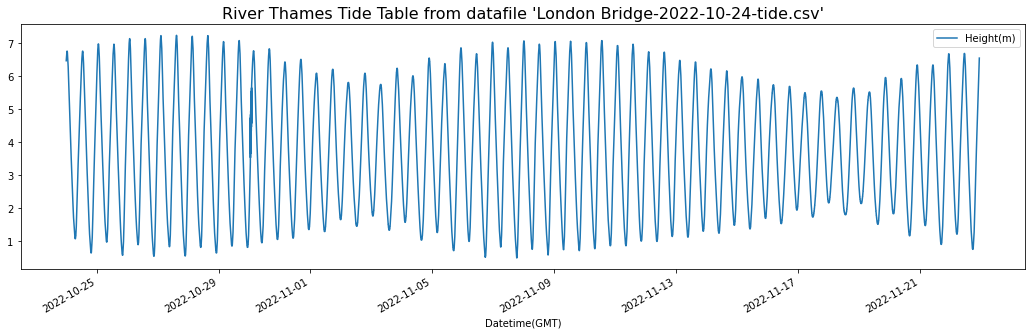

In [137]:
df.plot.line(figsize=(18, 5))
title = "River Thames Tide Table from datafile '" + filename + "'"
plt.title(title , fontsize = 16);

# Tide working windows calculator<a class="anchor" id="7"></a>

## Set start & end dates <a class="anchor" id="8"></a>

In [130]:
#dates on format 'YYYY-MM-DD'
start_date = '2022-11-01'
end_date = '2022-11-10'
df1 = df[start_date:end_date]

## Drop Sundays <a class="anchor" id="9"></a>

In [131]:
#drop Sundays from working shedule
df2 = df1.iloc[df1.index.dayofweek != 6]

## Set work shifts start & finish times <a class="anchor" id="10"></a>

In [132]:
#start and end time of working shift in format 'HH:MM'
start_time = '06:00'
end_time = '18:00'
df3 = df2[df2['UT(GMT)'].between(start_time, end_time)]

## Set tide height limit <a class="anchor" id="11"></a>

In [133]:
#tide height limiting the works
height_limit = 4
df4 = df3[df3['Height(m)'] <= height_limit]

## Plot tide chart <a class="anchor" id="12"></a>

In [134]:
#list of tuples with start and end of the working shifts
df_shift = df3[df3['UT(GMT)'].isin([start_time, end_time])]
shift = list(df_shift.index)
it = iter(shift)
shift = list(zip(it,it))

#list of tuples with start and end of the working tide windows
t1 = list(df4.index)[1:]
t1.append(list(df4.index)[-1] + pd.Timedelta("1 min"))

t2 = list(df4.index)[:-1]
t2.insert(0, list(df4.index)[0] - pd.Timedelta("1 min"))

df4['t1'], df4['t2'] = t1, t2
df4['tt1'] = df4['t1'] - df4.index
df4['tt2'] = df4.index - df4['t2']
df4['tt3'] = df4[['tt1','tt2']].max(axis = 1) 

if df4.iloc[0]['Height(m)'] <= height_limit:
    df4.iloc[0,7] = pd.Timedelta("10 min")
if df4.iloc[-1]['Height(m)'] <= height_limit:
    df4.iloc[-1,7] = pd.Timedelta("10 min")

milestones = list(df4[df4['tt3'] > '0 days 00:01:00'].index)
it = iter(milestones)
milestones = list(zip(it,it))

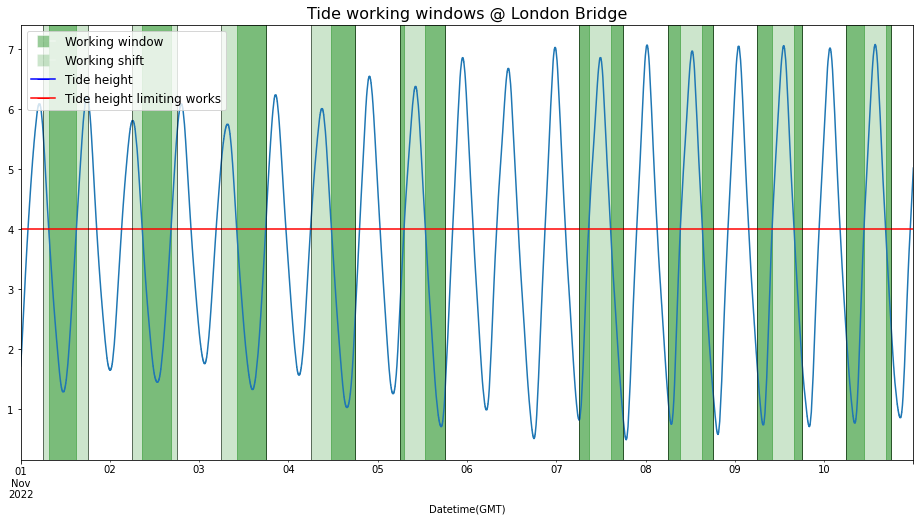

In [138]:
df1.plot.line(figsize=(16, 8))

plt.axhline(height_limit, color='r', linestyle='-')
plt.title('Tide working windows @ London Bridge', fontsize = 16);

#legend settings
legend_elements = [Line2D([0], [0], marker='s', color='w', alpha=0.4, label='Working window', markerfacecolor='g', markersize=12),
                  Line2D([0], [0], marker='s', color='w', alpha=0.2, label='Working shift', markerfacecolor='g', markersize=12),
                  Line2D([0], [0], marker='_', color='b', label='Tide height', markerfacecolor='b', markersize=12),
                  Line2D([0], [0], marker='_', color='r', label='Tide height limiting works', markerfacecolor='r', markersize=12)]                         
plt.legend(handles=legend_elements, loc=2, fontsize=12, frameon = True)

for d in shift:
    plt.axvspan(d[0], d[1] , 0, height_limit, alpha=0.2, color='green')
    plt.axvline(x = d[0], color = 'black',linestyle = '-', linewidth = 0.5)
    plt.axvline(x = d[1], color = 'black',linestyle = '-', linewidth = 0.5)
    
for d in milestones:
    plt.axvspan(d[0], d[1] , 0, height_limit, alpha=0.4, color='green')

## Report of tide working windows <a class="anchor" id="13"></a>

In [136]:
#time window for tidal works
total_time = 0
print('day/ date     / start  / end    / time window')
for (i,j) in milestones:
    print (i.day_name()[:3], i.date(), i.time(), j.time(), int((j-i)/pd.Timedelta('60s')), 'minutes')
    total_time += int((j-i)/pd.Timedelta('60s'))
print('----------------------------------------')
print('Total working time =', total_time, 'minutes')

day/ date     / start  / end    / time window
Tue 2022-11-01 07:35:00 15:00:00 445 minutes
Wed 2022-11-02 08:43:00 16:26:00 463 minutes
Thu 2022-11-03 10:06:00 17:51:00 465 minutes
Fri 2022-11-04 11:34:00 18:00:00 386 minutes
Sat 2022-11-05 06:00:00 07:03:00 63 minutes
Sat 2022-11-05 12:49:00 18:00:00 311 minutes
Mon 2022-11-07 06:00:00 08:40:00 160 minutes
Mon 2022-11-07 14:35:00 18:00:00 205 minutes
Tue 2022-11-08 06:00:00 09:20:00 200 minutes
Tue 2022-11-08 15:15:00 18:00:00 165 minutes
Wed 2022-11-09 06:00:00 10:00:00 240 minutes
Wed 2022-11-09 15:54:00 18:00:00 126 minutes
Thu 2022-11-10 06:00:00 10:42:00 282 minutes
Thu 2022-11-10 16:30:00 18:00:00 90 minutes
----------------------------------------
Total working time = 3601 minutes
